In [15]:
# Victor Z and Leo Gonzalez
# UW-Madison 2024
# Bayesian optimization for extraction system

import numpy as np
from matplotlib import pyplot as plt
from sklearn import gaussian_process as gpr
from scipy.optimize import minimize, Bounds

In [16]:
# define objective
def evalobj(x):
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    x1 = x[:, 0]
    x2 = x[:, 1]
    x3 = x[:, 2]

    # extraction model
    b = np.array([16.5780,
                  3.8563,
                  0.9250,
                  0.4212,
                  -1.2840,
                  -0.8515,
                  -1.0940,
                  -0.1425,
                  0.1900,
                  -0.1675])

    y = b[0]+b[1]*x1+b[2]*x2+b[3]*x3+b[4]*x1**2+b[5]*x2**2+b[6]*x3**2+b[7]*x1*x2+b[8]*x1*x3+b[9]*x2*x3

    return -y

# define acquisition function
def acqfunc(x, gprMdl):
    if len(x.shape) == 1:
        x = x.reshape(1, -1)

    mu, sig = gprMdl.predict(x, return_std = True)

    acq = mu-0.2*sig

    return acq

# define function to move from scaled space to real space
def descale(x, lb, ub, bounds):
        m = (ub-lb)/(bounds.ub-bounds.lb)
        b = ub-m*bounds.ub
        return m*x+b

In [17]:
## set initial database

# naive design
x = np.array([[0, 1, -1]]*3).T

N = len(x)
y = np.zeros((N, 1))

for i in range(N):
    y[i] = evalobj(x[i])

idx = np.argmin(y)
xit = x[idx]
yit = y[idx]
datax = x
datay = y

# set up BO components
nit = 20
lb = -1*np.ones(3)
ub = 1*np.ones(3)
bounds = Bounds(lb, ub)
dim = len(lb)

kernel = gpr.kernels.RBF(length_scale = np.ones(dim))
gprMdl = gpr.GaussianProcessRegressor(kernel = kernel,
                                      normalize_y = True)

for k in range(nit):
    # train kriging model with available data
    gprMdl.fit(datax, datay)
    # determine new experiment
    soln = minimize(fun = acqfunc,
                   x0 = xit,
                   method = 'SLSQP',
                   bounds = bounds,
                   args = (gprMdl,))

    xit = soln.x

    # evaluate objective at new point
    yit = evalobj(xit)

    # update database
    datax = np.vstack([datax, xit.reshape(1, -1)])
    datay = np.vstack([datay, yit.reshape(-1, 1)])

lb_actual = np.array([70, 1, 0.1])
ub_actual = np.array([100, 2, 0.3])
X_opt = descale(datax, lb_actual, ub_actual, bounds)
y = -np.vstack([np.min(y), datay[3:, :]])

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


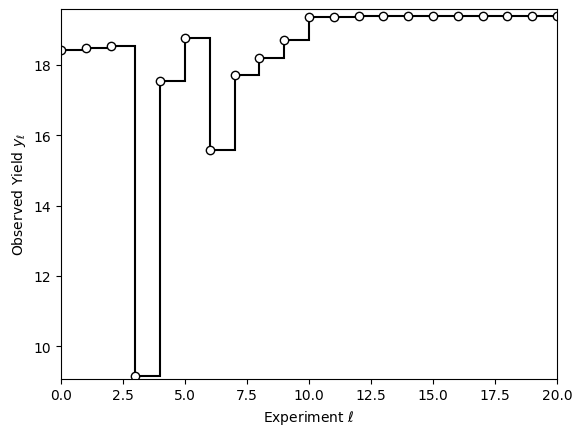

In [18]:
## plot results
plt.figure()
plt.stairs(y[:, 0], edges = np.linspace(0, nit+1, nit+2), baseline = None, linewidth = 1.5, color = 'k')
plt.scatter(np.linspace(0, nit, nit+1), y, marker ='o', color = 'w', edgecolor = 'k')
plt.ylim(0.99*np.min(y), 1.01*np.max(y))
plt.xlim(0, nit)
plt.xlabel(r'Experiment $\ell$')
plt.ylabel(r'Observed Yield $y_{\ell}$');